## MARBL diagnostics using tseries files

### MARBL - from one member of CESM2-LE


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image
import utils
import pandas as pd
import pop_tools

import tools

### Define latest year and get the CESM data

In [2]:
case = 'b.e21.BHISTcmip6.f09_g17.LE2-1301.010'
path = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ocn/proc/tseries/month_1/'

In [3]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'spCaCO3','diatC', 'spC','diazC','SALT',
             'PO4','Fe','NO3','SiO3','ALK','photoC_TOT_zint_100m','zooC',
            'IFRAC','diaz_Nfix',
            'spChl','diatChl','diazChl'] 

In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient()
cluster.scale(20) 
client

<Client: 'tcp://128.117.208.103:39571' processes=0 threads=0, memory=0 B>

In [6]:
cesm_mon_ds = xr.Dataset()
cesm_ann_ds = xr.Dataset()


for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_tmp = xr.open_dataset(path + var + '/' + case + '.pop.h.' + var + '.200001-200912.nc')
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds_tmp["time"] = ds_tmp.time_bound.compute().mean(dim="d2")
    
    ds_tmp1 = ds_tmp.mean(dim='time') #annual mean over the whole dataset for this variable
    ds_tmp2 = ds_tmp.groupby('time.month').mean('time').compute() #monthly climatology over the whole dataset for this variable
    
    cesm_ann_ds = xr.merge([cesm_ann_ds,ds_tmp1],combine_attrs='override')
    cesm_mon_ds = xr.merge([cesm_mon_ds,ds_tmp2],combine_attrs='override')

starting on  sp_Fe_lim_surf
starting on  sp_P_lim_surf
starting on  sp_N_lim_surf
starting on  diat_Fe_lim_surf
starting on  diat_P_lim_surf
starting on  diat_N_lim_surf
starting on  diat_SiO3_lim_surf
starting on  diaz_P_lim_surf
starting on  diaz_Fe_lim_surf
starting on  photoC_TOT_zint
starting on  photoC_sp_zint
starting on  photoC_diat_zint
starting on  photoC_diaz_zint
starting on  CaCO3_PROD_zint
starting on  SiO2_PROD
starting on  POC_FLUX_100m
starting on  spCaCO3
starting on  diatC
starting on  spC
starting on  diazC
starting on  SALT
starting on  PO4
starting on  Fe
starting on  NO3
starting on  SiO3
starting on  ALK
starting on  photoC_TOT_zint_100m
starting on  zooC
starting on  IFRAC
starting on  diaz_Nfix
starting on  spChl
starting on  diatChl
starting on  diazChl


### Make the annual mean

In [7]:
cesm_ann_ds #= cesm_mon_ds.mean(dim='time')

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables: (12/34)
    dz                    (z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    sp_Fe_lim_surf        (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    sp_P_lim_surf         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    sp_N_lim_surf         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    diat_Fe_lim_surf      (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    diat_P_lim_surf       (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    ...                    ...
    zooC                  (z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan
    IFRAC                 (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    diaz_Nfix             (z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan
    spChl                 (z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan
    diatChl               (z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan
    diazChl               (z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan

In [8]:
cesm_mon_ds

<xarray.Dataset>
Dimensions:               (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/34)
    dz                    (month, z_t) float32 1e+03 1e+03 ... 2.5e+04 2.5e+04
    sp_Fe_lim_surf        (month, nlat, nlon) float32 nan nan nan ... nan nan
    sp_P_lim_surf         (month, nlat, nlon) float32 nan nan nan ... nan nan
    sp_N_lim_surf         (month, nlat, nlon) float32 nan nan nan ... nan nan
    diat_Fe_lim_surf      (month, nlat, nlon) float32 nan nan nan ... nan nan
    diat_P_lim_surf       (month, nlat, nlon) float32 nan nan nan ... nan nan
    ...                    ...
    zooC                  (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    IFRAC                 (month, nlat, nlon) float32 nan nan nan ... nan nan
    diaz_Nfix             (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    spChl                 (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    diatChl               (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    diazChl               (month, z_t_150m, nlat, nlon) float32 nan nan ... nan

In [9]:
ds_grid = pop_tools.get_grid('POP_gx1v7')


lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
depths=ds_grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_grid.dz * 0.01

In [10]:
cesm_ann_ds = cesm_ann_ds.where(ds_grid.REGION_MASK > 0)

In [11]:
cesm_mon_ds = cesm_mon_ds.where(ds_grid.REGION_MASK > 0)

#### World Ocean Atlas 2013

In [12]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [13]:
ds_woa['z_t'] = cesm_ann_ds.z_t

In [14]:
NO3_diff = cesm_ann_ds.NO3 - ds_woa.NO3
PO4_diff = cesm_ann_ds.PO4 - ds_woa.PO4
SiO3_diff = cesm_ann_ds.SiO3 - ds_woa.SiO3

In [15]:
rmse_global = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})

In [16]:
#help(esmlab.statistics)
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [17]:
rmse_global.PO4.values

array([0.17264046, 0.17482858, 0.18254006, 0.19230192, 0.2047143 ,
       0.21706614, 0.22983294, 0.24122685, 0.25482605, 0.26690394,
       0.27341896, 0.27793446, 0.28496108, 0.28564621, 0.28941764,
       0.28968026, 0.286883  , 0.28753426, 0.28479389, 0.28580836,
       0.28339892, 0.28474677, 0.2830966 , 0.28406728, 0.2854282 ,
       0.28667678, 0.28790387, 0.28898386, 0.28763862, 0.28865705,
       0.28768573, 0.28318489, 0.27824959, 0.2717336 , 0.26986778,
       0.26823358, 0.27461   , 0.28958997, 0.30709975, 0.33637456,
       0.36783777, 0.39797382, 0.42023075, 0.42668346, 0.42970405,
       0.42239464, 0.41184584, 0.39968056, 0.38468473, 0.37234598,
       0.36231295, 0.36214046, 0.36979564, 0.38429233, 0.40746206,
       0.43422054, 0.46440776, 0.49773947, 0.53818957, 0.58000174])

In [18]:
rmse_global.NO3.values

array([ 2.64638267,  2.8078759 ,  2.93016372,  3.09819098,  3.29361666,
        3.48505664,  3.71628308,  3.96053578,  4.15627207,  4.3546004 ,
        4.43922774,  4.54074868,  4.7000621 ,  4.74507873,  4.85525055,
        4.94300285,  5.00772787,  5.12862917,  5.14692191,  5.22543957,
        5.36489118,  5.60598361,  5.65119143,  5.753093  ,  6.02487343,
        6.35888981,  6.79924492,  7.34905425,  7.84967024,  8.44194409,
        8.99394451,  9.57265483, 10.1248989 , 10.77665812, 11.47021818,
       11.88936785, 12.09426375, 12.01250342, 11.45065134, 10.57744976,
        9.34771317,  8.00744478,  6.66681788,  5.60100743,  4.89082127,
        4.58956395,  4.56323939,  4.6295851 ,  4.69668522,  4.72766224,
        4.76298681,  4.821779  ,  4.94415179,  5.17154716,  5.51371086,
        5.87049277,  6.2325284 ,  6.6420746 ,  7.18572988,  7.80876516])

In [19]:
rmse_global.SiO3.values

array([ 7.6464949 ,  7.75638359,  7.76132471,  7.87186101,  8.01263371,
        8.17787907,  8.39174145,  8.62945776,  8.92836633,  9.1372618 ,
        9.34606729,  9.53825851,  9.72478249,  9.83407488,  9.9585098 ,
       10.02963065, 10.06393161, 10.1488186 , 10.08603466, 10.11764861,
       10.06842234, 10.10642054, 10.04777675, 10.0661408 , 10.12150914,
       10.19439639, 10.31422968, 10.45591004, 10.5729991 , 10.82419148,
       11.19710921, 11.60765659, 12.08202337, 12.79721293, 13.56909485,
       14.22710787, 14.47749666, 14.3962176 , 14.25064921, 13.57600198,
       12.7267839 , 12.26275998, 12.20240616, 13.27737724, 14.29786659,
       15.14358203, 15.92393961, 16.85980688, 18.11601523, 19.91160151,
       22.20744792, 24.95408162, 28.08561653, 31.64547605, 35.49446966,
       39.4269065 , 43.37629855, 47.67007119, 53.06774729, 60.22263608])

#### Surface nutrients

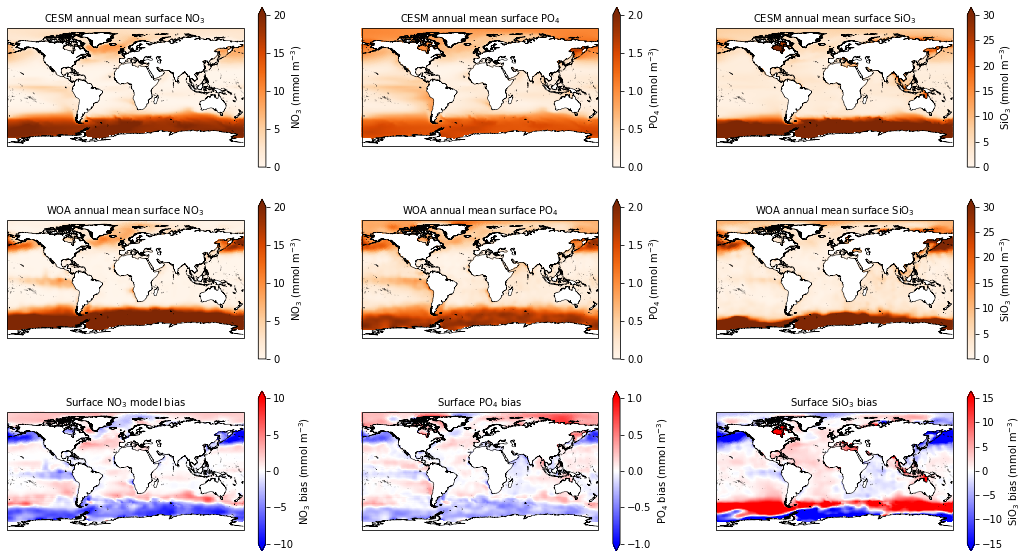

In [20]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.NO3.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.PO4.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.SiO3.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



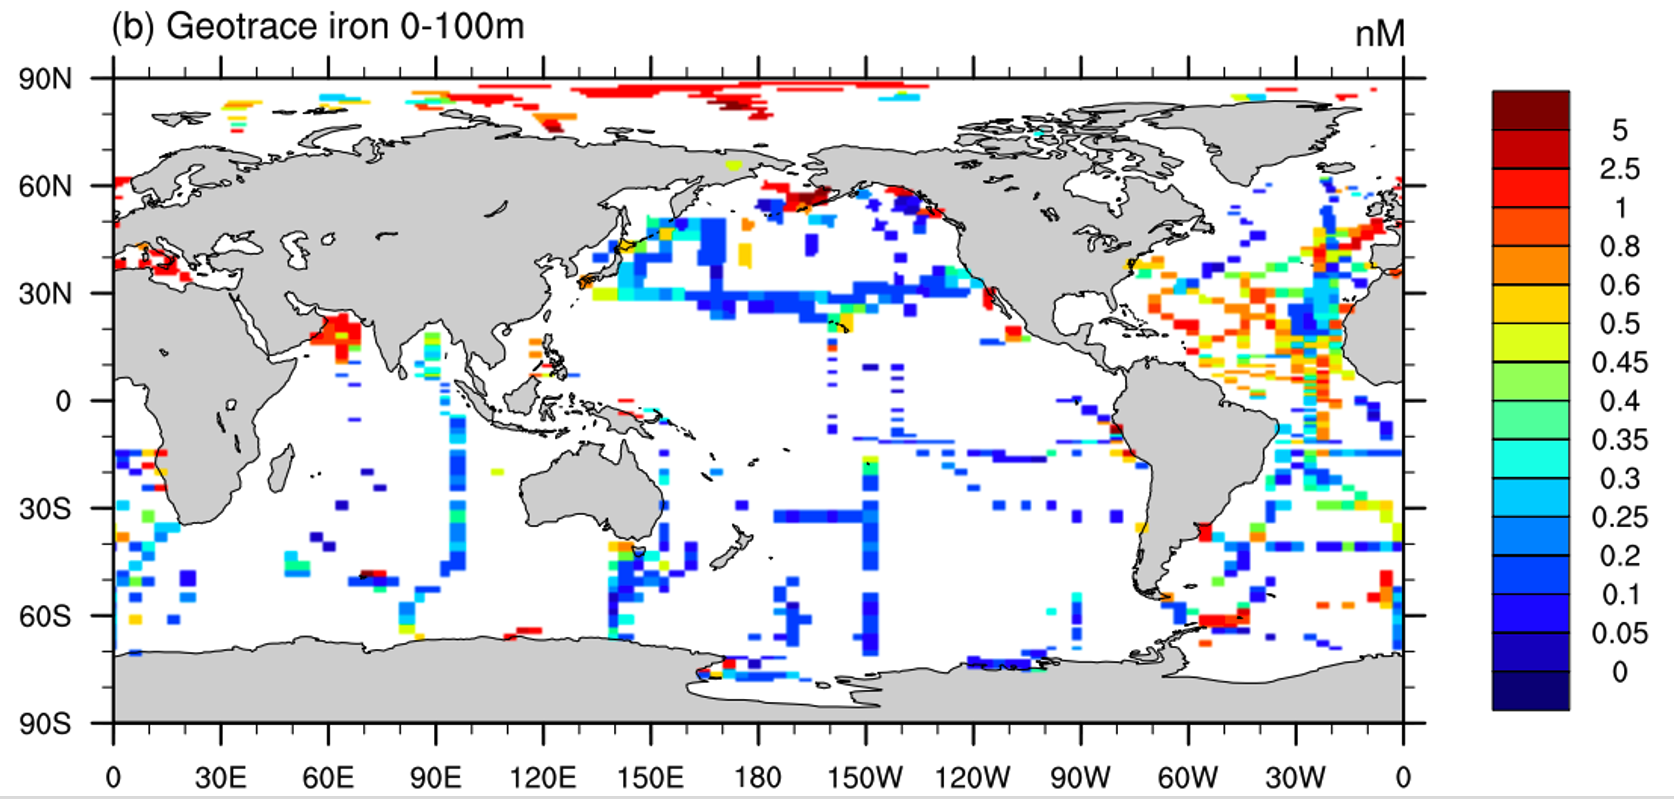

In [21]:
Image(filename='/glade/work/kristenk/Fe_obs/Fe_concs.png')
# df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
# df

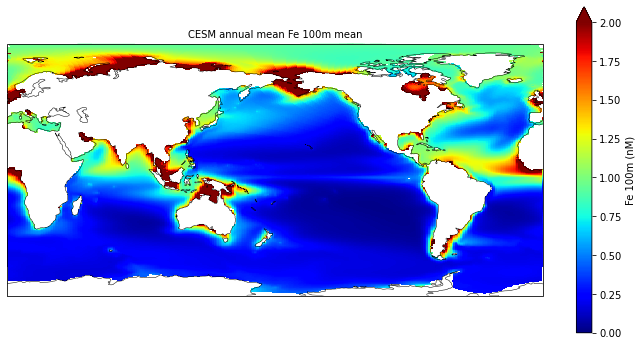

In [22]:
fig = plt.figure(figsize=(12,6))

#---- CESM panel
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree(central_longitude=0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean Fe 100m mean', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.Fe.isel(z_t=slice(0,10)).mean(dim='z_t')*1e3)
pc1=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=2, cmap='jet',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Fe 100m (nM)')

# #---- OBS panel
# ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
# ax.coastlines('10m',linewidth=0.5)
# ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
# pc2=ax.pcolormesh(lon, lat, 
#                  field, vmin=0, vmax=20, cmap='Oranges',
#                  transform=ccrs.PlateCarree())
# cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

### Global nutrient profiles

In [23]:
ds_glb = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb['NO3']= esmlab.weighted_mean(cesm_ann_ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(cesm_ann_ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(cesm_ann_ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [24]:
ds_glb_woa = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

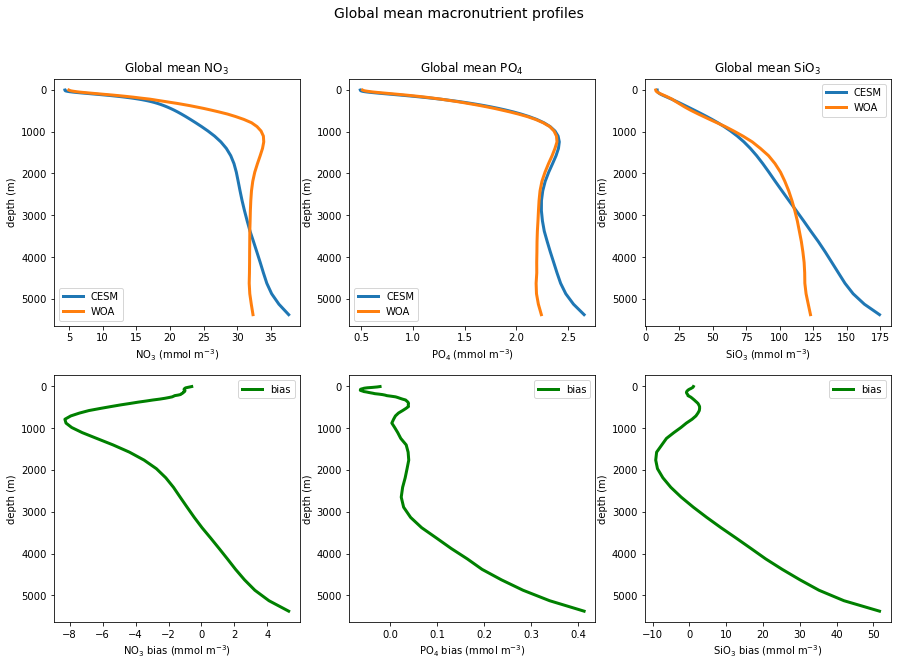

In [25]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Phytoplankton nutrient limitation at surface

In [28]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)

limarray_sp=xr.concat((cesm_ann_ds.sp_P_lim_surf, cesm_ann_ds.sp_Fe_lim_surf,cesm_ann_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds.diat_P_lim_surf, cesm_ann_ds.diat_Fe_lim_surf, cesm_ann_ds.diat_N_lim_surf, cesm_ann_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds.diaz_P_lim_surf, cesm_ann_ds.diaz_Fe_lim_surf),dim='nutrient')

In [29]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [30]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()

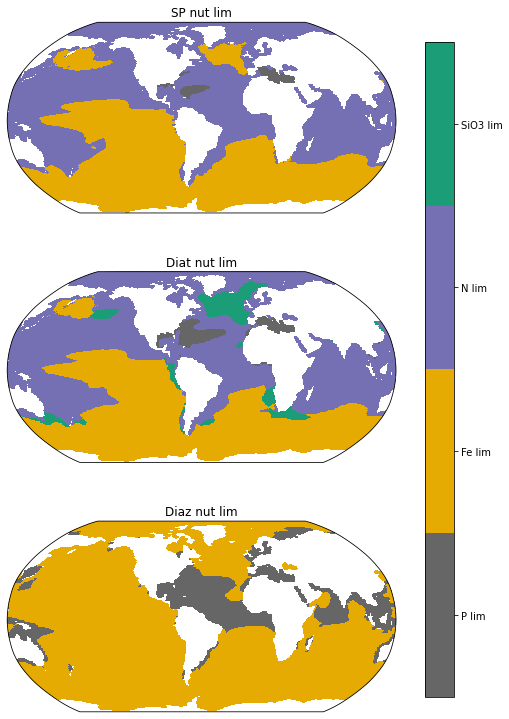

In [31]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3 lim']);

### Monthly nutrient limitations

In [32]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)

limarray_sp=xr.concat((cesm_mon_ds.sp_P_lim_surf, cesm_mon_ds.sp_Fe_lim_surf,cesm_mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds.diat_P_lim_surf, cesm_mon_ds.diat_Fe_lim_surf, cesm_mon_ds.diat_N_lim_surf, cesm_mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds.diaz_P_lim_surf, cesm_mon_ds.diaz_Fe_lim_surf),dim='nutrient')

In [33]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [34]:
cesm_mon_ds

<xarray.Dataset>
Dimensions:               (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/34)
    dz                    (month, z_t) float32 1e+03 1e+03 ... 2.5e+04 2.5e+04
    sp_Fe_lim_surf        (month, nlat, nlon) float32 nan nan nan ... nan nan
    sp_P_lim_surf         (month, nlat, nlon) float32 nan nan nan ... nan nan
    sp_N_lim_surf         (month, nlat, nlon) float32 nan nan nan ... nan nan
    diat_Fe_lim_surf      (month, nlat, nlon) float32 nan nan nan ... nan nan
    diat_P_lim_surf       (month, nlat, nlon) float32 nan nan nan ... nan nan
    ...                    ...
    zooC                  (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    IFRAC                 (month, nlat, nlon) float32 nan nan nan ... nan nan
    diaz_Nfix             (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    spChl                 (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    diatChl               (month, z_t_150m, nlat, nlon) float32 nan nan ... nan
    diazChl               (month, z_t_150m, nlat, nlon) float32 nan nan ... nan

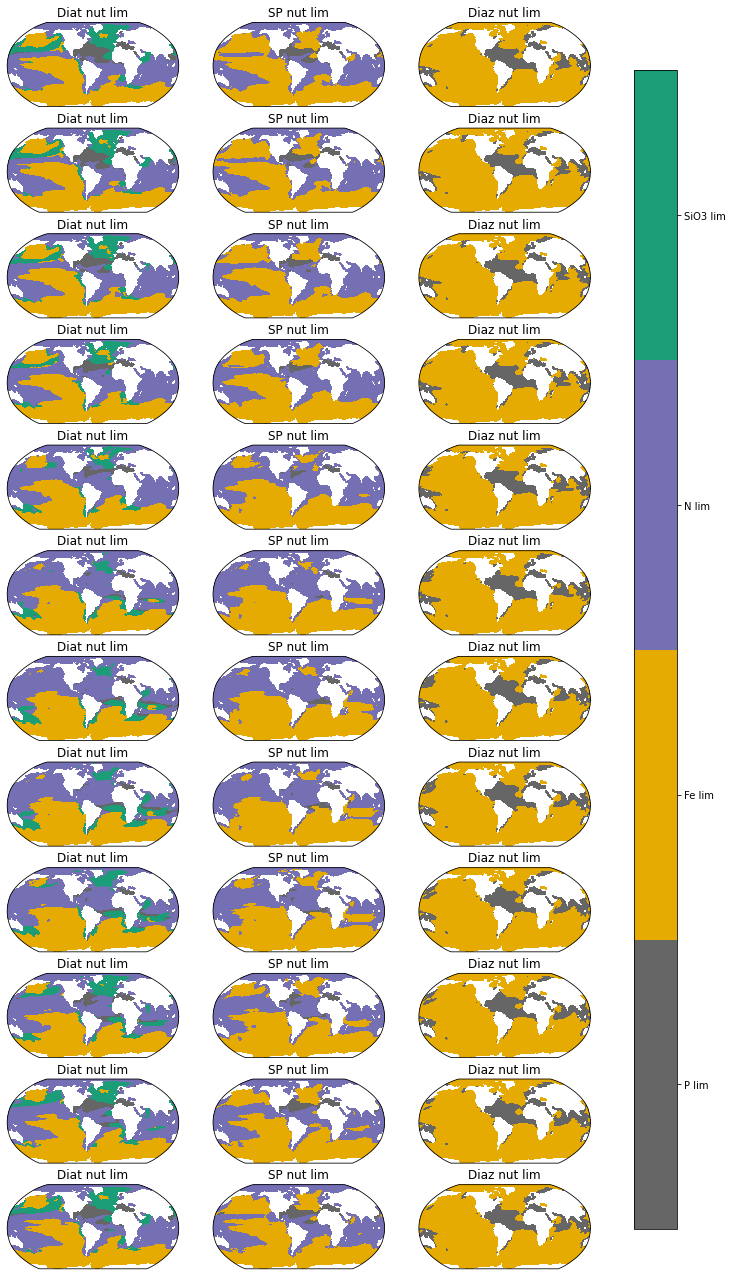

In [35]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat nut lim', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diat.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP nut lim', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_sp.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diaz nut lim', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diaz.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3 lim']);

### Look at phyto carbon pools

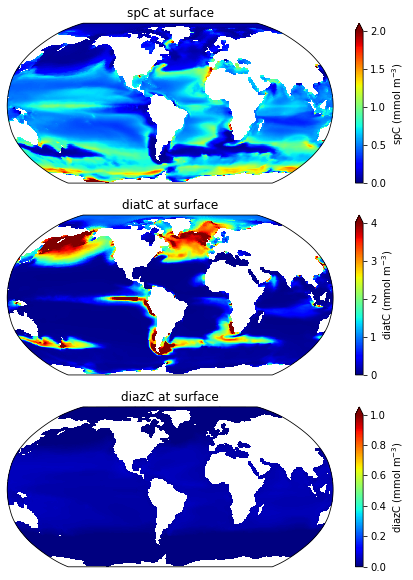

In [36]:
###### 
fig = plt.figure(figsize=(8,10))


ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

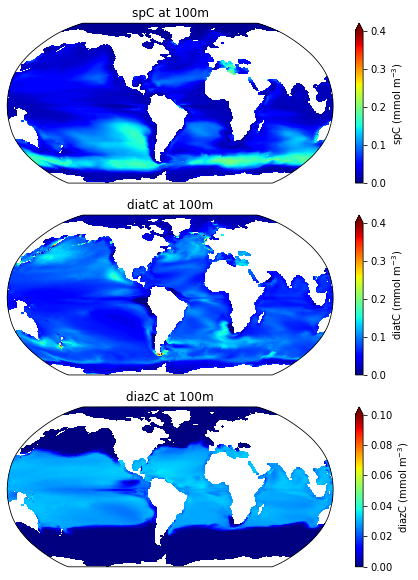

In [37]:
###### 
fig = plt.figure(figsize=(8,10))


ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

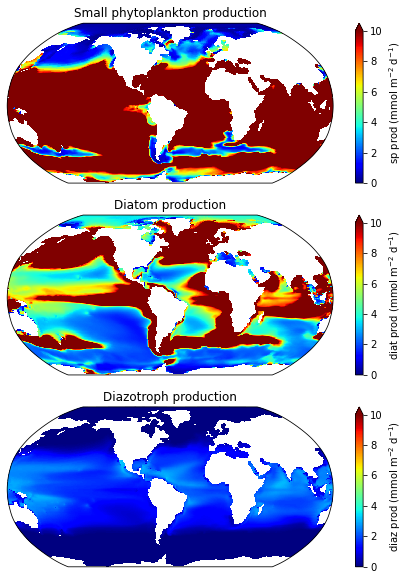

In [38]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds.photoC_sp_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds.photoC_diat_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds.photoC_diaz_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')


### Look at percent phytoC

In [40]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

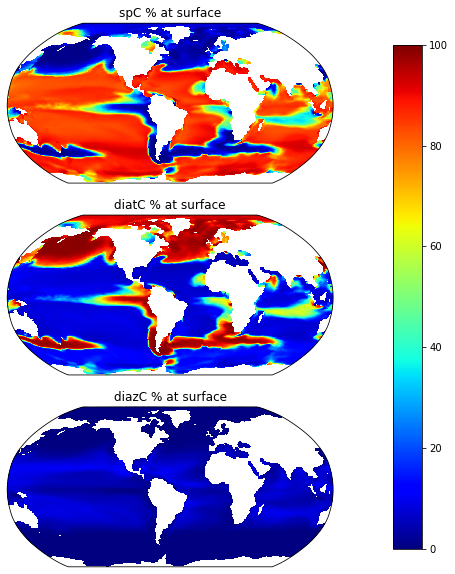

In [41]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_diat.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_sp.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_diaz.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

### Compute diatom fraction and then estimate mesozoo/microzoo

In [43]:
cesm_ann_ds['diat_frac'] = cesm_ann_ds.diatC / (cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.spC)

In [44]:
cesm_ann_ds['mesozooC'] = cesm_ann_ds['diat_frac'] * cesm_ann_ds['zooC']
cesm_ann_ds['microzooC'] = cesm_ann_ds['zooC'] - cesm_ann_ds['mesozooC']

### Plot zooC

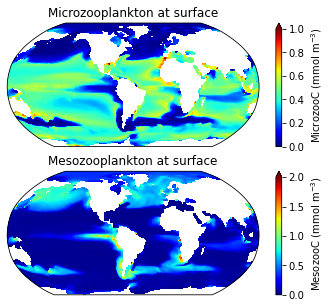

In [45]:
fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.microzooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MicrozooC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.mesozooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MesozooC (mmol m$^{-3}$)');


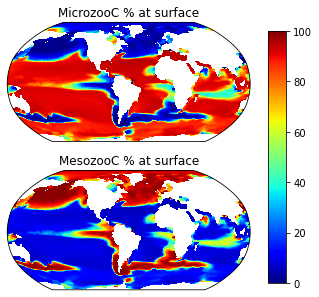

In [46]:
zooC = cesm_ann_ds.microzooC + cesm_ann_ds.mesozooC
perc_microzoo = cesm_ann_ds.microzooC / (zooC) * 100.
perc_mesozoo = cesm_ann_ds.mesozooC / (zooC) * 100.

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MicrozooC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_microzoo.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MesozooC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_mesozoo.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax);

In [47]:
microzoo_biomass= esmlab.weighted_sum(cesm_ann_ds.microzooC, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
microzoo_biomass = microzoo_biomass * 10. #mmol
microzoo_biomass = microzoo_biomass.sum(dim='z_t_150m')
microzoo_biomass = microzoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

print('Microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is ', np.round(microzoo_biomass,4), ' Pg C.')


mesozoo_biomass= esmlab.weighted_sum(cesm_ann_ds.mesozooC, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
mesozoo_biomass = mesozoo_biomass * 10. #mmol
mesozoo_biomass = mesozoo_biomass.sum(dim='z_t_150m')
mesozoo_biomass = mesozoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

print('Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013). Here it is ', np.round(mesozoo_biomass,4), ' Pg C.')

Microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is  0.1022  Pg C.
Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013). Here it is  0.0691  Pg C.


### NPP

In [48]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [49]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:           ()
Data variables:
    photoC_diat_zint  float64 17.77
    photoC_sp_zint    float64 29.25
    photoC_diaz_zint  float64 1.855
    photoC_TOT_zint   float64 48.88

In [50]:
print('diatom NPP is ', np.round((ds_glb['photoC_diat_zint']/ds_glb['photoC_TOT_zint']*100.).values,2),'% of total NPP.')

diatom NPP is  36.35 % of total NPP.


### Chlorophyll comparison

In [52]:
chl_file = '/glade/work/kristenk/satellite_data/Chl_cumulative_mean/A20021852020182.L3m_CU_CHL_chlor_a_9km.nc'
ds_chl = xr.open_dataset(chl_file, decode_times=False)
#units are mg/m3
tot_chl = cesm_ann_ds.spChl.isel(z_t_150m=0) + cesm_ann_ds.diatChl.isel(z_t_150m=0) + cesm_ann_ds.diazChl.isel(z_t_150m=0)

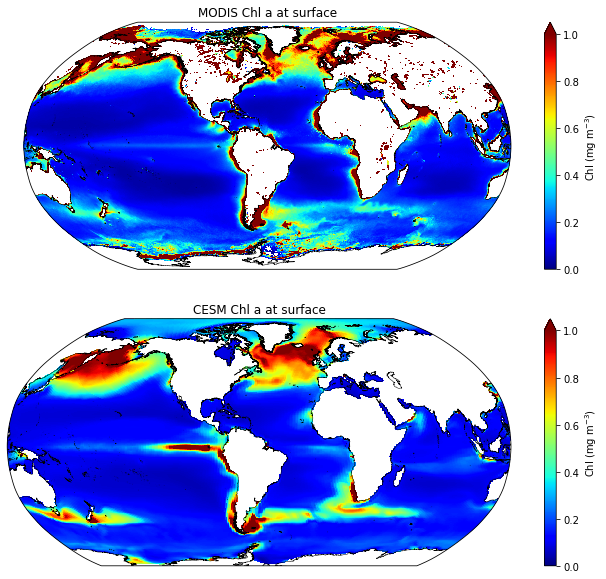

In [53]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_chl.lon.values, ds_chl.lat.values, ds_chl.chlor_a, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tot_chl)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


In [46]:
import matplotlib.colors as colors

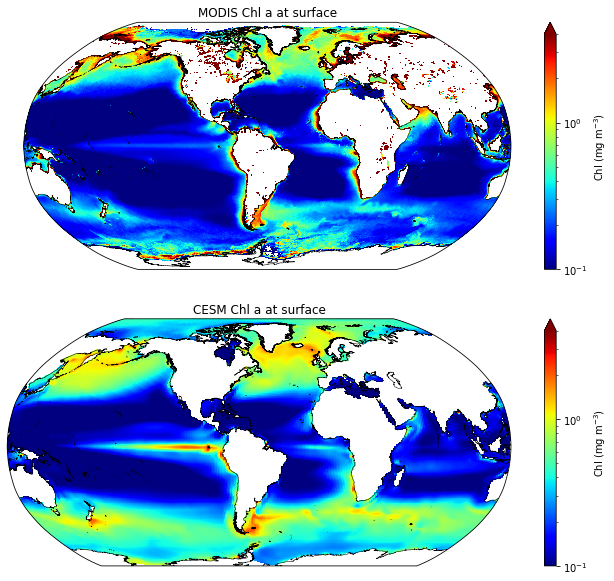

In [47]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_chl.lon.values, ds_chl.lat.values, ds_chl.chlor_a, cmap='jet',
                 norm=colors.LogNorm(vmin=0.1, vmax=4),
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tot_chl)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 norm=colors.LogNorm(vmin=0.1, vmax=4),
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


### MAREDAT Micozooplankton/zoo1+zoo2 comparison

In [56]:
file = '/glade/work/kristenk/MAREDAT/microzooplankton/mean_fields/MAREDAT_microzoo_means.nc'
maredat_microzoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

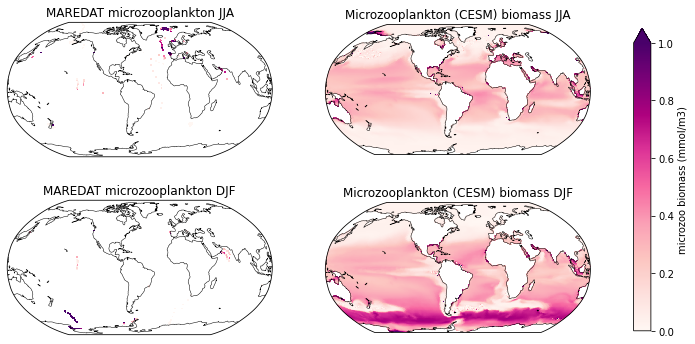

In [97]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton JJA', fontsize=12)
tmp = maredat_microzoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='month')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton DJF', fontsize=12)
tmp = maredat_microzoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='month')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max',label='microzoo biomass (mmol/m3)');

### COPEPOD comparison (Mesozooplankton)

In [58]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

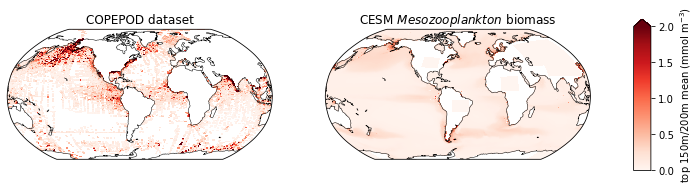

In [59]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
tmp = ds_copepod.copepod_C
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
tmp = cesm_ann_ds.mesozooC.mean(dim='z_t_150m')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')

### compare to spatially interpolated COPEPOD climatology
#### (dataset is in units of mgC/m2, despite its being labeled otherwise, personal communication with Colleen Petrik)

In [60]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)

In [61]:
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

In [63]:
cesm_mon_ds['diat_frac'] = cesm_mon_ds.diatC / (cesm_mon_ds.diatC + cesm_mon_ds.diazC + cesm_mon_ds.spC)

In [65]:
cesm_mon_ds['mesozooC'] = cesm_mon_ds['diat_frac'] * cesm_mon_ds['zooC']
cesm_mon_ds['microzooC'] = cesm_mon_ds['zooC'] - cesm_mon_ds['mesozooC']

### depth integrate CESM and convert to same units

In [66]:
### depth integrate and convert model to mol/m2
cesm_mon_ds['mesozooC_zint'] = ((cesm_mon_ds.mesozooC) * 10.).sum(dim='z_t_150m') #in mmol/m2

cesm_mon_ds['mesozooC_zint'] = cesm_mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

In [67]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

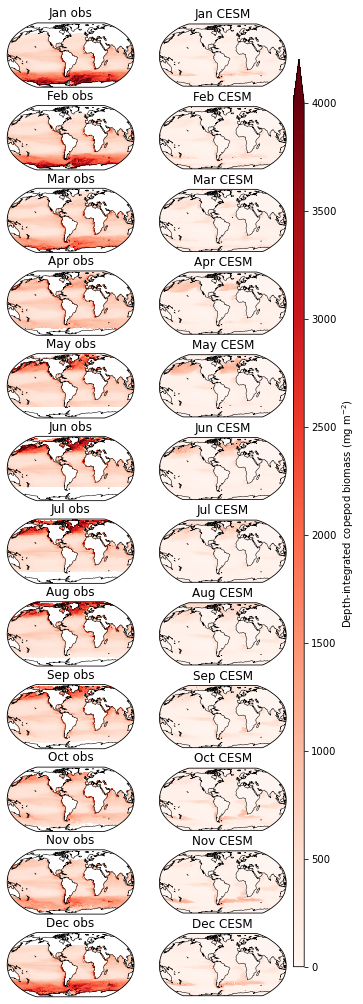

In [68]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(month=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

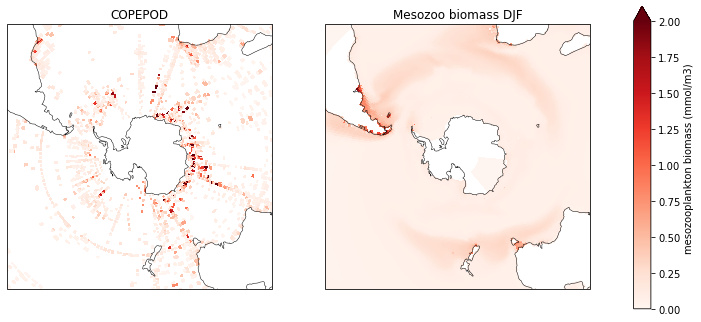

In [69]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('COPEPOD')
tmp = ds_copepod.copepod_C
lon,lat,field = utils.adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lons_sh, lats_sh, field, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_ann_ds.mesozooC.mean(dim='z_t_150m')
lon,lat,field = utils.adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]


ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Mesozoo biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())


ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='mesozooplankton biomass (mmol/m3)');
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

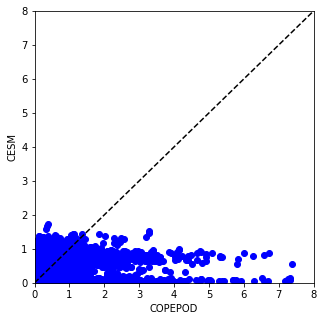

In [70]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database
one2one = np.array([0, 8])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(5,5))   
#set up the vals
y_vals = cesm_ann_ds.mesozooC.isel(z_t_150m=0).values
y_vals = y_vals.flatten()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_vals,y_vals,color='blue',marker='o',
           label='control')
ax.set_ylabel('CESM')
ax.set_xlabel('COPEPOD')
ax.set_ylim(0,8)
ax.set_xlim(0,8)
ax.plot(one2one,one2one,color='black',linestyle='--')

### Calcification

In [71]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(cesm_ann_ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',np.round(ds_glb['CaCO3_PROD_zint'].values,4), 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 0.9174 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [72]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)

#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

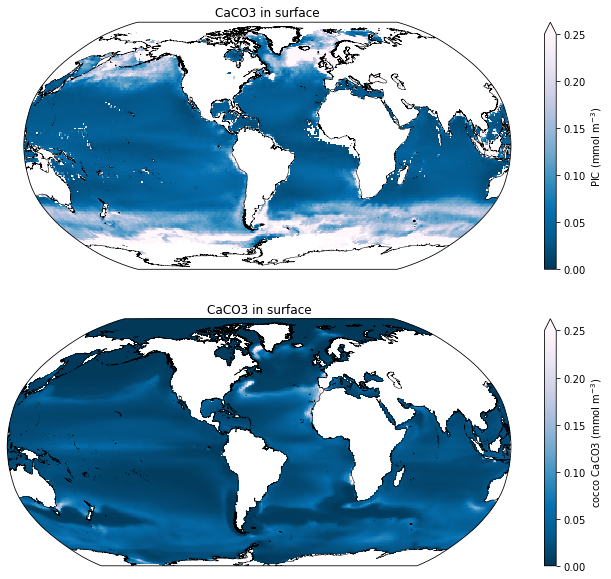

In [73]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.spCaCO3.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


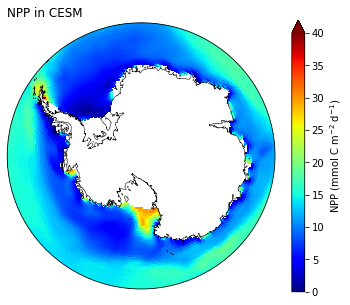

In [74]:
fig = plt.figure(figsize=(6,5))

import matplotlib.path as mpath
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP in CESM', loc='left')
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.photoC_TOT_zint*86400*0.01)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=40, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol C m$^{-2}$ d$^{-1}$)')

#fig.savefig('/glade/work/kristenk/figs/npp.png', bbox_inches='tight', dpi=300, format='png');

### N fixation

In [75]:
#global integral
tmp = cesm_ann_ds['diaz_Nfix'] * 10. #multiply by the thickness of each layer in the top 150m (10m)
tmp = tmp.sum(dim='z_t_150m').where(cesm_ann_ds.photoC_TOT_zint>-100.) # unit is mmol/m2/s
ds_glb['diaz_Nfix'] = esmlab.statistics.weighted_sum(tmp, weights=area_m, dim=['nlat', 'nlon'])
ds_glb['diaz_Nfix'] = ds_glb['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glb['diaz_Nfix'].values
print('Globally integrated marine nitrogen fixation is',np.round(ds_glb['diaz_Nfix'].values,4), 'Tg N per year')
print('(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)')

Globally integrated marine nitrogen fixation is 247.9555 Tg N per year
(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)


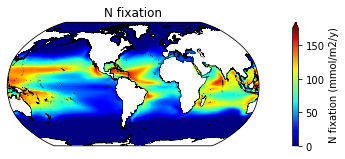

In [76]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('N fixation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp*86400. * 365.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 #vmin=0,vmax=2,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='N fixation (mmol/m2/y)')


### Alkalinity

In [77]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_ALK_SALT.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=cesm_ann_ds.z_t

In [78]:
#rmse_global['ALK']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.ALK, ds_glodap.ALK, dim=['nlat', 'nlon'], weights=area)

### Salinity normalized ALK
ds_glodap['sAlk'] = ds_glodap.ALK/ds_glodap.SALT * 35.

In [79]:
cesm_ann_ds['sAlk'] = cesm_ann_ds.ALK/cesm_ann_ds.SALT * 35

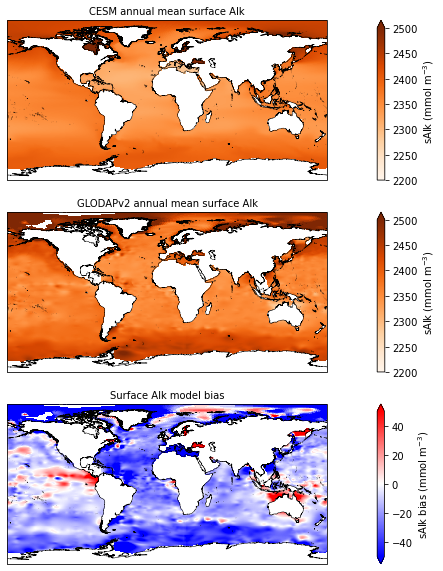

In [80]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.sAlk.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAPv2 annual mean surface Alk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_glodap.sAlk.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- DIFF panel
sALK_diff = cesm_ann_ds.sAlk - ds_glodap.sAlk

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  sALK_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-50, vmax=50, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='sAlk bias (mmol m$^{-3}$)')

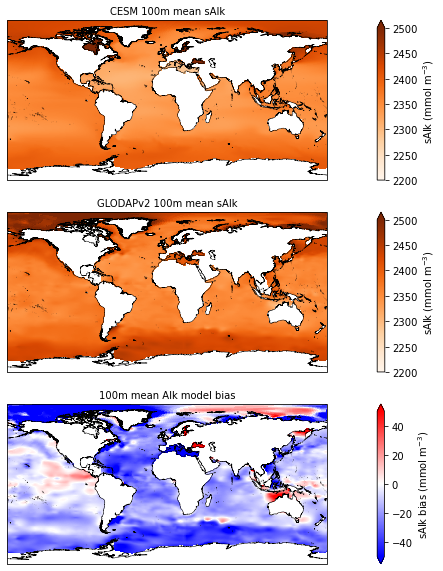

In [81]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM 100m mean sAlk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.sAlk.isel(z_t=slice(0,10)).mean(dim='z_t'))
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAPv2 100m mean sAlk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_glodap.sAlk.isel(z_t=slice(0,10)).mean(dim='z_t'))
pc2=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- DIFF panel
sALK_diff = cesm_ann_ds.sAlk - ds_glodap.sAlk

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('100m mean Alk model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  sALK_diff.isel(z_t=slice(0,10)).mean(dim='z_t'))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-50, vmax=50, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='sAlk bias (mmol m$^{-3}$)')

### Global POC export

In [82]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(cesm_ann_ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr
ds_glb['POC_FLUX_100m'].values
print('Globally integrated POC flux is',ds_glb['POC_FLUX_100m'].values, 'Pg C per year')

Globally integrated POC flux is 7.022579961232937 Pg C per year


### Export ratio

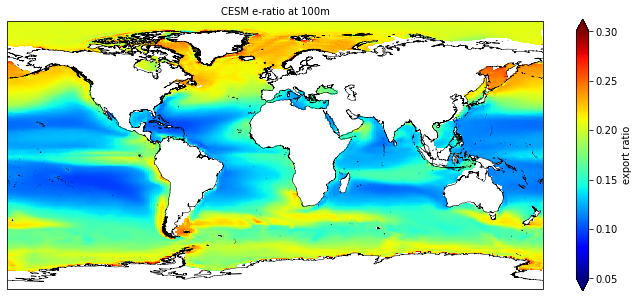

In [83]:
#plot E-RATIO
eratio = cesm_ann_ds.POC_FLUX_100m/cesm_ann_ds.photoC_TOT_zint_100m

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM e-ratio at 100m', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  eratio)
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='jet',
                  vmin=0.05, vmax=0.3, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='export ratio')


### Let's look at Fe

In [84]:
nmolcm3_to_nM = 1e3
cesm_ann_ds['Fe'] = cesm_ann_ds['Fe'] * nmolcm3_to_nM
cesm_ann_ds['Fe'].attrs['units'] = 'nM'

In [85]:
# file = '/glade/work/kristenk/Fe_obs/Fe_obs_gx3v7.nc'
# Fe_obs = xr.open_dataset(file)
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')

In [86]:
%%time

df.obs_stream.add_model_field(cesm_ann_ds.Fe)

CPU times: user 4.71 s, sys: 67.6 ms, total: 4.77 s
Wall time: 5.14 s


In [87]:
df

lon      lat   depth   dFe_obs        Fe
0      210.010 -16.0018    20.0  0.540000  0.058266
1      210.010 -16.0018    35.0  0.440000  0.058674
2      210.010 -16.0019    50.0  0.480000  0.060929
3      210.010 -16.0019    80.0  0.400000  0.076930
4      210.010 -16.0020   100.0  0.390000  0.092792
...        ...      ...     ...       ...       ...
27777  160.051  47.0032  3929.6  0.825681  0.807628
27778  160.051  47.0032  3929.8  0.902248  0.807618
27779  160.051  47.0032  4900.4  0.555630       NaN
27780  160.051  47.0032  4900.9  0.621851       NaN
27781  160.051  47.0032  5210.1  0.573220       NaN

[27782 rows x 5 columns]

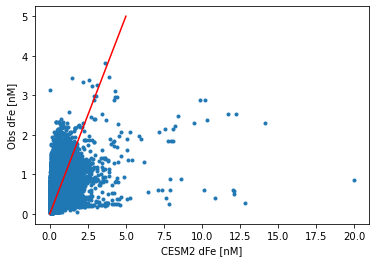

In [88]:
plt.plot(df.dFe_obs, df.Fe, '.')
plt.xlabel('CESM2 dFe [nM]')
plt.ylabel('Obs dFe [nM]')
plt.plot([0, 5], [0, 5], 'r-')

In [91]:
import plot
import matt_utils
import matplotlib.gridspec as gridspec

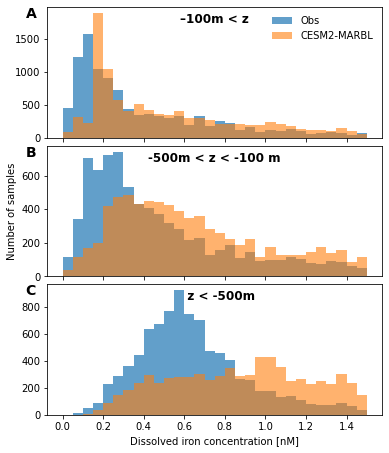

In [92]:
fig, axs = plot.canvas(3, 1, figsize=(6, 2.5), use_gridspec=True, hspace=0.06)

dx = 0.05
bin_edges = np.arange(0., 1.5+dx, dx)
bins = np.vstack((bin_edges[:-1], bin_edges[1:])).mean(axis=0)

depth_ranges = {
    '–100m < z': (0., 100.),
    '-500m < z < -100 m': (100., 500.),
    '   z < -500m': (500., 1e36),
}

for n, (key, depth_range) in enumerate(depth_ranges.items()):
    ax = axs[n, 0]
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    hist, _ = np.histogram(df_sub.dFe_obs.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.7, label='Obs')
    
    hist, _ = np.histogram(df_sub.Fe.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.6, label='CESM2-MARBL')
    
    if n == 0:
        ax.legend(loc='upper right', frameon=False)
    if n < 2:
        ax.set_xticklabels([])
    ylm = ax.get_ylim()
    ax.text(0.75, ylm[1] - 0.12 * np.diff(ylm), key, 
            fontweight='bold',
            fontsize=12,
            ha='center',
           )
    if n == 1:
        ax.set_ylabel('Number of samples')
    if n == 2:
        ax.set_xlabel('Dissolved iron concentration [nM]')
        
matt_utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.05, yoff=-0.02)               
#utils.savefig('iron-global-ocean-obs-PDF')

In [93]:
dsp = matt_utils.pop_add_cyclic(cesm_ann_ds)

In [94]:
from itertools import product
import cmocean
import matplotlib.colors as colors

In [96]:
# field = 'Fe'

# levels = {'Fe': [0., 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1., 2.5, 5.0]}


# fig = plt.figure(figsize=(10, 8))
# prj = ccrs.Robinson(central_longitude=305.0)

# nrow, ncol = 3, 2 
# gs = gridspec.GridSpec(
#     nrows=nrow, ncols=ncol+1, 
#     width_ratios=(1, 1, 0.03),
#     wspace=0.05, 
#     hspace=0.2,
# )

# axs = np.empty((nrow, ncol)).astype(object)
# caxs= np.empty((nrow, ncol)).astype(object)
# for i, j in product(range(nrow), range(ncol)):    
#     axs[i, j] = plt.subplot(gs[i, j], projection=prj)
# cax = plt.subplot(gs[:, -1])

# cmap_field = cmocean.cm.dense


# for i, (key, depth_range) in enumerate(depth_ranges.items()):
#     for j in range(2):
#         ax = axs[i, j]
#         if j == 0:
#             zslice = slice(depth_range[0]*100., depth_range[1]*100.)

#             cf = ax.contourf(
#                 dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
#                 levels=levels[field],
#                 extend='max',
#                 cmap=cmap_field,
#                 norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
#                 transform=ccrs.PlateCarree(),
#             )
#         else:
#             df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
#             sc = ax.scatter(
#                 df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
#                 cmap=cmap_field,
#                 norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
#                 s=6,
#                 transform=ccrs.PlateCarree(),
#             )

#         land = ax.add_feature(
#             cartopy.feature.NaturalEarthFeature(
#                 'physical','land','110m',
#                 edgecolor='face',
#                 facecolor='gray'
#             )
#         )  

# cb = plt.colorbar(cf, cax=cax, ticks=levels['Fe'])
# if 'units' in dsp[field].attrs:
#     cb.ax.set_title(dsp[field].attrs['units'])
#     cb.ax.set_yticklabels([f'{f:g}' for f in levels['Fe']])

# matt_utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
# matt_utils.subplot_row_labels(axs[:, 0], depth_ranges.keys(), xoff=60)
    
# matt_utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       

In [ ]:
cluster.close()